# Mining data from GitHub

## Немного посмотрим на данные и приведем к удобному формату

Импортируем библиотеки и создадим необходимые папки.

In [1]:
import pydriller
import os
import json
from dpu_utils.utils import save_jsonl_gz, load_json_gz, RichPath
import numpy as np

from collections import namedtuple, defaultdict
import json
from tqdm import tqdm
from joblib import Parallel, delayed, cpu_count
%load_ext autoreload
%autoreload 2

os.chdir('D:\github_data')

commit_data_dir = 'extracted_data'
os.makedirs(commit_data_dir, exist_ok=True)

Попробуем запустить `RepositoryMining` для конкретного репозитория и посмотреть на пару примеров.

In [2]:
repo = pydriller.RepositoryMining('temp/react-native')
for i, commit in enumerate(repo.traverse_commits()):   
    print("Author: {}".format(commit.author.name),
          "commited at: {}".format(commit.author_date),
          "message: {}".format(commit.msg),
          "number of modifications: {}".format(len(commit.modifications)),
          sep='\n')
    print()

    if i == 1: 
        for m in  commit.modifications:
            print("modified: {}".format(m.filename),
                  "modification type: {}".format(m.change_type),
                  "with diff \n{}".format(m.diff),
                  sep='\n')
            print()
            break
        break

Author: Ben Alpert
commited at: 2015-01-29 17:10:49-08:00
message: Initial commit
number of modifications: 382

Author: Alex Kotliarskyi
commited at: 2015-01-30 10:17:28-08:00
message: Added ability to jump to syntax errors from RedBox
number of modifications: 1

modified: RCTRootView.m
modification type: ModificationType.MODIFY
with diff 
@@ -90,7 +90,12 @@ NSString *const RCTRootViewReloadNotification = @"RCTRootViewReloadNotification"
 - (void)bundleFinishedLoading:(NSError *)error
 {
   if (error != nil) {
-    [[RCTRedBox sharedInstance] showErrorMessage:error.localizedDescription withDetails:error.localizedFailureReason];
+    NSArray *stack = [[error userInfo] objectForKey:@"stack"];
+    if (stack) {
+      [[RCTRedBox sharedInstance] showErrorMessage:[error localizedDescription] withStack:stack];
+    } else {
+      [[RCTRedBox sharedInstance] showErrorMessage:[error localizedDescription] withDetails:[error localizedFailureReason]];
+    }
   } else {
     
     [_bridge.uiMa

### Отличия от открытого датасета

Дифф немного отличается от формате в открытом датасета, который я использовала ранее:

1. Нет каких-то дополнительных конструкций в начале диффа. Например, в случае добавления файла перед основным диффом было еще что-то такое:

    ```
    new file mode 100644
    index 00000000000 . . 99a8c86917d
    mmm / dev / null
    ppp b / docs / cas - server - documentation / protocol / Protocol - Overview . md
    ```

    Вроде как не хватает флага `--summary` в `git diff` (это мое предположение, не нашла в статье Jiang et al., какой именно дифф они использовали), а еще в `pydriller` нет удобной возможности его добавить :( 
    Самое простое - вручную генерировать подобные строчки перед основным диффом в соответствии с `ModificationType`. Но в открытом датасете было очень много строчек вида `Binary files x and y differ`, не очень понятно, будут ли они здесь вообще.

2. В одном коммите может быть несколько изменений, у каждого свой дифф. В открытом датасете же во всех примерах изменяется только один файл. 

    Можно попробовать конкатенировать диффы из всех изменений, но мы в любом случае не сможем обрабатывать бесконечно длинные диффы, нужно придумать, что делать с такими коммитами - просто отбрасывать/брать какую-то часть диффов/etc.?


### Предобработка данных для каждого коммита

Хочется сохранить следующую информацию для каждого коммита:

* автор
* дата
* сообщение
* диффы из всех изменений (потом решим, что с этим делать)

При этом каждый дифф нужно немного предобработать:

1. Добавить префикс на основе ModificationType

    <details>
      <summary>Подробнее про префиксы</summary>

      Есть следующие типы изменений: `ADD, COPY, RENAME, DELETE, MODIFY, UNKNOWN`.  

      * в случае `ADD` добавить что-то вроде 
        ```
        new file
        {название файла}
        ```

    * `COPY` можно совсем отбросить

    * в случае `RENAME` добавить что-то вроде 

        ```
        rename from {название файла до}
        rename to {название файла после}
        ```

    * в случае `DELETE` добавить что-то вроде

        ```
        deleted file
        {название файла}
        ```

    * в случае `MODIFY` добавить что-то вроде

        ```
        {название файла}
        ```

    * `UNKNOWN` можно совсем отбросить
    </details>

2. Убрать ненужные "служебные" строчки
3. Выделить знаки пунктуации пробелами
4. Удалить неизмененные строчки 
    (просто чтобы хоть немного сократить диффы, на открытом датасете такой подход показал себя хорошо)

Для этого я написала небольшой класс, посмотрим на результат его работы:

In [3]:
from commit_processor import CommitProcessor


repo = pydriller.RepositoryMining('temp/react-native')
for i, commit in enumerate(repo.traverse_commits()):
    if i == 0:
        continue # first example is kinda huge
    a = CommitProcessor.process_commit(commit)
    break
a

{'author': ('Alex Kotliarskyi', 'alex.frantic@gmail.com'),
 'date': '30.01.2015 10:17:28',
 'message': 'Added ability to jump to syntax errors from RedBox',
 'diff': ['ReactKit \\ Base \\ RCTRootView . m \\n - ( void ) bundleFinishedLoading : ( NSError * ) error \\n - [ [ RCTRedBox sharedInstance ] showErrorMessage : error . localizedDescription withDetails : error . localizedFailureReason ] ; \\n + NSArray * stack = [ [ error userInfo ] objectForKey : @ " stack " ] ; \\n + if ( stack ) { \\n + [ [ RCTRedBox sharedInstance ] showErrorMessage : [ error localizedDescription ] withStack : stack ] ; \\n + } else { \\n + [ [ RCTRedBox sharedInstance ] showErrorMessage : [ error localizedDescription ] withDetails : [ error localizedFailureReason ] ] ; \\n + } \\n']}

## Начнем собирать данные

> На данный момент данные собираются из репозиториев, предоставленных в датасете для NNGen. 
  Возможно, стоит вместо этого посмотреть топ N Java-репозиториев на данный момент.
  
Выгрузим из текстового файла названия репозиториев и ссылки на них.

In [4]:
# read urls of github repos to scrape from repo-id-to-github.txt
# TODO: better to scrape top-30 Java repos from GitHub API?
with open('repo-id-to-github.txt', 'r') as file:
    repo_dict = {line.strip().split()[1] : line.strip().split()[2] for line in file.readlines()[:75]}
    
repo_list = list(repo_dict.keys())

Соберем из 75 репозиториев по ~1000 последних коммитов, удовлетворяющих ограничениям на длину диффов и сообщений.

In [5]:
from process_repo import process_repo  # getting error if I don't move this to separate .py file

with Parallel(cpu_count()) as pool:
    data = pool(delayed(process_repo)(repo_name, repo_dict[repo_name]) for repo_name in repo_list)

## Немного посмотрим на собранные данные

Для начала загрузим их в один датафрейм.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gzip

pd.options.display.float_format = '{:.2f}'.format


dfs = []

for filename in tqdm(os.listdir(commit_data_dir)):
    with gzip.open(os.path.join(commit_data_dir, filename)) as f:
        df = pd.read_json(f, lines=True)
        df['repo'] = f'{filename.split(".jsonl.gz")[0]}'
        dfs.append(df)

100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 12.41it/s]


In [6]:
df = pd.concat(dfs, ignore_index=True, axis=0)
df.author = df.author.apply(lambda x: tuple(x))
df['diff_len'] = df['diff'].apply(lambda x: sum([len(diff.split()) for diff in x]))
df['message_len'] = df['message'].apply(lambda x: len(x.split()))
df.drop(df[df['diff_len'] == 0].index, inplace=True)
df.head()

,author,date,message,diff,repo,diff_len,message_len
0,"(Jake Wharton, jw@squareup.com)",2013-07-29 09:09:07,[ maven - release - plugin ] prepare release 4...,[actionbarsherlock - fest \ pom . xml \n - < v...,ActionBarSherlock,410,14
1,"(googolmo, googolmo@gmail.com)",2013-07-15 10:31:48,update android build tools to 0 . 5 . +,[build . gradle \n - classpath ' com . android...,ActionBarSherlock,52,10
2,"(Jake Wharton, jw@squareup.com)",2013-02-07 22:23:04,Use ' sw ' and ' w ' qualifiers on ICS + only .,[actionbarsherlock \ src \ com \ actionbarsher...,ActionBarSherlock,64,14
3,"(Jake Wharton, jw@squareup.com)",2013-02-07 21:26:41,Mention the ' library ' folder is now called '...,[website \ faq . html \n + < p > < em > Note :...,ActionBarSherlock,47,18
4,"(bbcallen, bbcallen@gmail.com)",2013-06-27 13:35:18,abs _ _ search _ view . xml : remove android n...,[actionbarsherlock \ res \ layout \ abs _ _ se...,ActionBarSherlock,37,24


In [7]:
len(df)

33270

### Статистика по коммитам для каждого автора

In [8]:
author_df = df.groupby(by='author')['date'].count()
author_df.describe()

count   5188.00
mean       6.41
std       30.87
min        1.00
25%        1.00
50%        1.00
75%        2.00
max      894.00
Name: date, dtype: float64

Всего есть 5188 уникальных авторов, у большинства из них очень мало коммитов, что печально. Попробуем оставить только авторов, у которых есть хотя бы 6 коммитов.

In [9]:
author_list = author_df.index[author_df > 5].tolist()
df = df.loc[df['author'].isin(author_list)]

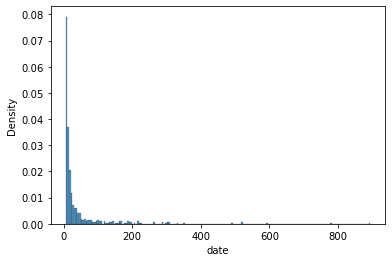

In [10]:
sns.histplot(x='date', data=df.groupby(by='author')['date'].count().reset_index(), stat='density')
plt.show()

In [11]:
print(len(df))
print(len(author_list))

26549
707


Таких авторов всего 707, и при этом мы теряем ~7000 примеров.

### Статистика по количеству токенов в диффах

В данном случае токенизация проводится просто разделением по пробелам. При сборе данных отбрасываются все примеры, где в диффах более 512 токенов (это максимальная длина входных данных для RoBERTa). Понятно, что при использовании другого токенизатора может получиться другое количество токенов, но мне показалось, что учитывать именно токенизатор RoBERTa при сборе данных будет как-то долго и громоздко.

In [12]:
df['diff_len'].describe()

count   26549.00
mean      176.17
std       133.31
min         5.00
25%        62.00
50%       135.00
75%       264.00
max       512.00
Name: diff_len, dtype: float64

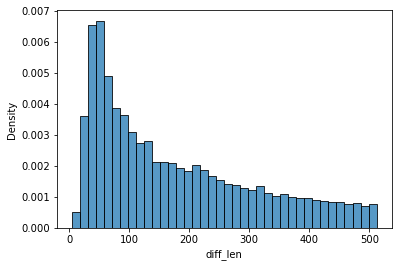

In [13]:
sns.histplot(df['diff_len'], stat='density')
plt.show()

В целом, большинство диффов не такие уж и длинные - 75% имеют не более 264 токенов.

### Статистика по количеству токенов в сообщениях

Аналогично диффам, сообщения разбиваются на токены по пробелам, и примеры с сообщениями с более чем 512 токенами были отброшены еще на этапе сбора. Посмотрим на статистику по оставшимся.

In [14]:
df['message_len'].describe()

count   26549.00
mean       32.09
std        39.96
min         8.00
25%        11.00
50%        16.00
75%        37.00
max       502.00
Name: message_len, dtype: float64

In [15]:
df['message_len'].median()

16.0

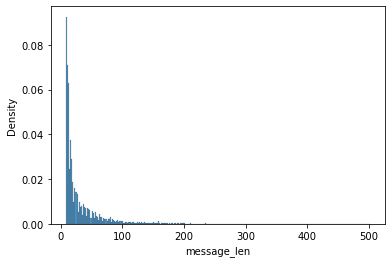

In [16]:
sns.histplot(df['message_len'], stat='density')
plt.show()

В целом, большинство сообщений действительно очень короткие: 75% имеют не более 37 токенов.

### Сохраним данные в формате открытого датасета

Открытый датасет был разбит на trait и test части, в каждой из них хранилось по три файла: с сообщениями, с диффами, и с id репозитория. Сделаем примерно то же самое, но с id автора, а еще отсортируем по времени.

In [17]:
# отсортируем датафрейм так, чтобы у каждого автора коммиты шли в соответствии с датой, от самых ранних к самым поздним
df.sort_values(by=['author', 'date'], inplace=True)

# заменим авторов на что-то вроде id, чтобы было проще
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['author'] = df['author'].apply(lambda x: x[0] + '<SEP>' + x[1]) # label encoder doesn't work with tuples
df['author'] = le.fit_transform(df['author'])

# сделаем из диффов-списков диффы-строки
df['diff'] = df['diff'].apply(lambda x: ' '.join(x))

In [18]:
df.head()

,author,date,message,diff,repo,diff_len,message_len
19930,0,2020-01-09 14:20:10,Fix JavaDoc of RuleBasedIpFilter ( # 10521 ) \...,handler \ src \ main \ java \ io \ netty \ han...,netty,51,70
19880,0,2020-02-11 13:07:13,Fix typo in Http2FrameCodec # write ( . . . ) ...,codec - http2 \ src \ main \ java \ io \ netty...,netty,71,99
19879,0,2020-02-11 19:25:51,Remove extra empty line ( # 10754 ) \n Motivat...,codec - http2 \ src \ main \ java \ io \ netty...,netty,26,60
19878,0,2020-03-11 13:55:18,Add ` toString ` method in DefaultHttp2WindowU...,codec - http2 \ src \ main \ java \ io \ netty...,netty,88,76
19877,0,2020-03-11 13:56:51,HttpConversionUtil # toHttpResponse should use...,codec - http2 \ src \ main \ java \ io \ netty...,netty,329,115


Теперь нужно как-то разделить это на условные train и test. Ни одной модели не нужно обучаться, но для distilGPT-2 предполагается наличие некоторой истории, в случае с открытым датасетом я брала её как раз из train.

Пока используется такая простая идея: группируем по автору, в каждой группе берем 3 последних коммита, их используем для оценки качества моделей. Все остальные используются как история в случае distilGPT-2.

In [19]:
test_idxs = df.groupby('author').apply(lambda x: x.tail(3)).index.get_level_values(1)
test_df = df.loc[test_idxs]
test_df.shape

(2121, 7)

In [20]:
test_df.head(33)

,author,date,message,diff,repo,diff_len,message_len
19911,0,2020-12-10 21:43:58,Add checkInRange in ObjectUtil ( # 10668 ) \n ...,common \ src \ main \ java \ io \ netty \ util...,netty,264,75
19847,0,2020-12-22 23:43:33,Change switch to if ( # 10880 ) \n Motivation ...,codec - http \ src \ main \ java \ io \ netty ...,netty,120,64
19836,0,2021-01-01 23:49:44,Update BouncyCastle Libraries ( # 10906 ) \n M...,pom . xml \n - < version > 1 . 65 < / version ...,netty,52,63
7410,1,2021-02-24 11:35:11,[ DOCS ] Remove beta admonition for runtime fi...,docs \ painless \ painless - contexts \ painle...,elasticsearch,100,36
7593,1,2021-03-02 14:52:38,[ DOCS ] Updating ILM phase language ( # 68477 ),docs \ reference \ ilm \ update - lifecycle - ...,elasticsearch,369,11
7805,1,2021-11-01 13:50:06,Minor revision missed in merge . ( # 67282 ),docs \ reference \ mapping . asciidoc \n - app...,elasticsearch,193,10
21650,2,2014-08-02 19:22:58,fix # 184 : OkHttp no longer uses default ssl ...,okhttp \ src \ main \ java \ com \ squareup \ ...,okhttp,448,12
21593,2,2014-08-05 09:09:35,Remove FIXME from Huffman as it is good enough .,okhttp \ src \ main \ java \ com \ squareup \ ...,okhttp,27,10
21649,2,2014-11-02 08:58:37,"Add - X to okcurl , permitting HEAD requests .",okcurl \ src \ main \ java \ com \ squareup \ ...,okhttp,87,10
23051,3,2021-01-29 12:15:00,API : Suppress existing NullableCollections li...,core \ java \ android \ window \ TaskOrganizer...,platform_frameworks_base,39,30


In [21]:
idxs_bool = df.index.isin(test_idxs)
train_df = df[~idxs_bool]
train_df.shape

(24428, 7)

In [22]:
train_df.head()

,author,date,message,diff,repo,diff_len,message_len
19930,0,2020-01-09 14:20:10,Fix JavaDoc of RuleBasedIpFilter ( # 10521 ) \...,handler \ src \ main \ java \ io \ netty \ han...,netty,51,70
19880,0,2020-02-11 13:07:13,Fix typo in Http2FrameCodec # write ( . . . ) ...,codec - http2 \ src \ main \ java \ io \ netty...,netty,71,99
19879,0,2020-02-11 19:25:51,Remove extra empty line ( # 10754 ) \n Motivat...,codec - http2 \ src \ main \ java \ io \ netty...,netty,26,60
19878,0,2020-03-11 13:55:18,Add ` toString ` method in DefaultHttp2WindowU...,codec - http2 \ src \ main \ java \ io \ netty...,netty,88,76
19877,0,2020-03-11 13:56:51,HttpConversionUtil # toHttpResponse should use...,codec - http2 \ src \ main \ java \ io \ netty...,netty,329,115


In [38]:
def save_df(df, folder):
    msgs = list(item[1]+'\n' for item in df['message'].items())
    with open(os.path.join(folder, 'msg.txt'), 'w', encoding='utf-8') as target:
        target.writelines(msgs)
        
    authors = list(str(item[1])+'\n' for item in df['author'].items())
    with open(os.path.join(folder, 'projectIds.txt'), 'w', encoding='utf-8') as target:
        target.writelines(authors)
        
    diffs = list(item[1]+'\n' for item in df['diff'].items())
    with open(os.path.join(folder, 'diff.txt'), 'w', encoding='utf-8') as target:
        target.writelines(diffs)

In [39]:
os.makedirs('data', exist_ok=True)
os.makedirs('data/train', exist_ok=True)
os.makedirs('data/test', exist_ok=True)
save_df(train_df, 'data/train')
save_df(test_df, 'data/test')